# Grad-CAM Analysis of Residual Fusion Model

This notebook uses Gradient-weighted Class Activation Mapping (Grad-CAM) to
interpret the residual CNN used in the final multimodal property valuation model.

The goal is to visualize which spatial regions of satellite imagery contribute
to the residual corrections applied on top of the XGBoost baseline.


**Note:**  
Grad-CAM is applied only to the residual CNN, not to the tabular XGBoost model,
as convolutional networks operate directly on spatial image features.


In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

import torch
import torch.nn as nn
from torch.utils.data import DataLoader


In [3]:
import sys

PROJECT_ROOT = Path.cwd().parent
sys.path.append(str(PROJECT_ROOT))
BASE_DIR = Path("/Users/prabh/Desktop/ML/property_valuation")
DATA_DIR = BASE_DIR / "data"
PROCESSED_DIR = DATA_DIR / "processed"
IMAGES_DIR = DATA_DIR / "images"
OUTPUT_DIR = BASE_DIR / "outputs"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)


cuda


In [4]:
from src.models import CNNResidualRegressor

model = CNNResidualRegressor().to(DEVICE)
model.load_state_dict(
    torch.load(
        OUTPUT_DIR / "adaptive_fusion_final.pth",
        map_location=DEVICE,
        weights_only=True
    )
)

model.eval()

print(model)


CNNResidualRegressor(
  (image_encoder): CNNImageEncoder(
    (backbone): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1

In [5]:
def find_last_conv_layer(model):
    for module in reversed(list(model.modules())):
        if isinstance(module, torch.nn.Conv2d):
            return module
    raise ValueError("No Conv2d layer found")

target_layer = find_last_conv_layer(model)
print("Using target layer:", target_layer)


Using target layer: Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


In [6]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None
        self._register_forward_hook()

    def _register_forward_hook(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
            output.register_hook(self._save_gradient)

        self.target_layer.register_forward_hook(forward_hook)

    def _save_gradient(self, grad):
        self.gradients = grad

    def generate(self, x):
        # Ensure gradients are enabled
        x.requires_grad_(True)

        self.model.zero_grad()

        out = self.model(x)
        out = out.sum()          # make scalar
        out.backward()

        if self.gradients is None:
            raise RuntimeError("Gradients not captured. Check requires_grad.")

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1)

        cam = torch.relu(cam)
        cam -= cam.min()
        cam /= (cam.max() + 1e-8)

        return cam


In [7]:
from src.dataset import PropertyDataset

val_ds = PropertyDataset(
    PROCESSED_DIR / "val_with_xgb.csv",
    IMAGES_DIR,
    split="train",         
    mode="residual",
    zooms=("zoom16",),
    xgb_pred_col="xgb_pred"
)


In [8]:
img_tensor, _ = val_ds[0]
img_tensor = img_tensor.unsqueeze(0).to(DEVICE)


In [9]:
pid = int(pd.read_csv(PROCESSED_DIR / "val_with_xgb.csv").iloc[0]["id"])
img_path = IMAGES_DIR / "zoom16" / "train" / f"{pid}.png"

orig_img = cv2.imread(str(img_path))
orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)


In [10]:
grad_cam = GradCAM(model, target_layer)

cam = grad_cam.generate(img_tensor)
cam = cam.squeeze().detach().cpu().numpy()

cam = cv2.resize(
    cam,
    (orig_img.shape[1], orig_img.shape[0])
)


c:\Users\prabh\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\autograd\graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [11]:
heatmap = cv2.applyColorMap(
    (255 * cam).astype("uint8"),
    cv2.COLORMAP_JET
)

overlay = cv2.addWeighted(
    orig_img, 0.6,
    heatmap, 0.4,
    0
)


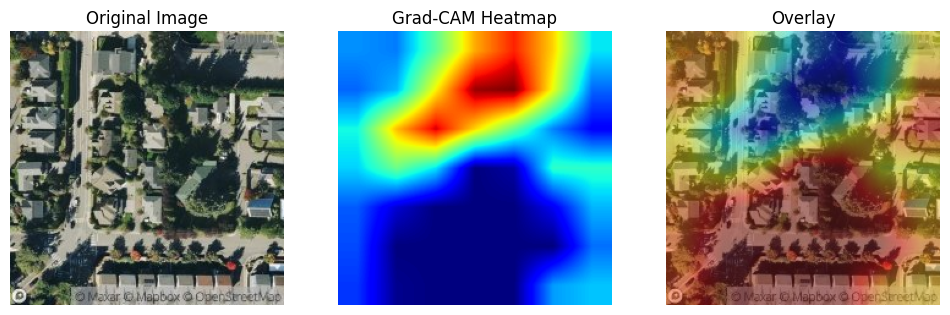

In [12]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(orig_img)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(cam, cmap="jet")
plt.title("Grad-CAM Heatmap")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(overlay)
plt.title("Overlay")
plt.axis("off")

plt.show()


## Interpretation

The Grad-CAM visualization highlights spatial regions that influence the
residual correction predicted by the CNN.

The model primarily focuses on:
- Road networks and connectivity
- Dense built-up areas
- Local neighborhood structure

These spatial cues are not explicitly encoded in tabular features, confirming
that satellite imagery provides complementary information.


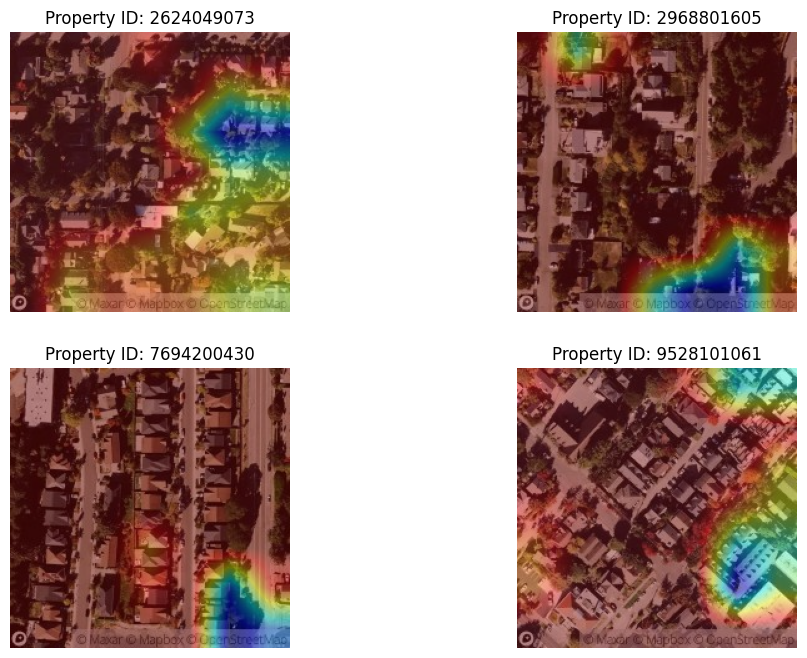

In [13]:
indices = [1, 5, 10, 20]

plt.figure(figsize=(12, 8))

for i, idx in enumerate(indices):
    img_tensor, _ = val_ds[idx]
    img_tensor = img_tensor.unsqueeze(0).to(DEVICE)

    pid = int(pd.read_csv(PROCESSED_DIR / "val_with_xgb.csv").iloc[idx]["id"])
    img_path = IMAGES_DIR / "zoom16" / "train" / f"{pid}.png"

    orig_img = cv2.cvtColor(
        cv2.imread(str(img_path)),
        cv2.COLOR_BGR2RGB
    )

    cam = grad_cam.generate(img_tensor).squeeze().detach().cpu().numpy()
    cam = cv2.resize(cam, (orig_img.shape[1], orig_img.shape[0]))

    heatmap = cv2.applyColorMap(
        (255 * cam).astype("uint8"),
        cv2.COLORMAP_JET
    )
    overlay = cv2.addWeighted(orig_img, 0.6, heatmap, 0.4, 0)

    plt.subplot(2, 2, i + 1)
    plt.imshow(overlay)
    plt.title(f"Property ID: {pid}")
    plt.axis("off")

plt.show()


In [14]:
val_df = pd.read_csv(PROCESSED_DIR / "val_with_xgb.csv")

y_true = val_df["log_price"].values
xgb_pred = val_df["xgb_pred"].values

residuals = y_true - xgb_pred


In [15]:
pos_indices = np.where(residuals > np.percentile(residuals, 90))[0][:2]
neg_indices = np.where(residuals < np.percentile(residuals, 10))[0][:2]

print("Positive residual indices:", pos_indices)
print("Negative residual indices:", neg_indices)


Positive residual indices: [19 22]
Negative residual indices: [ 4 21]


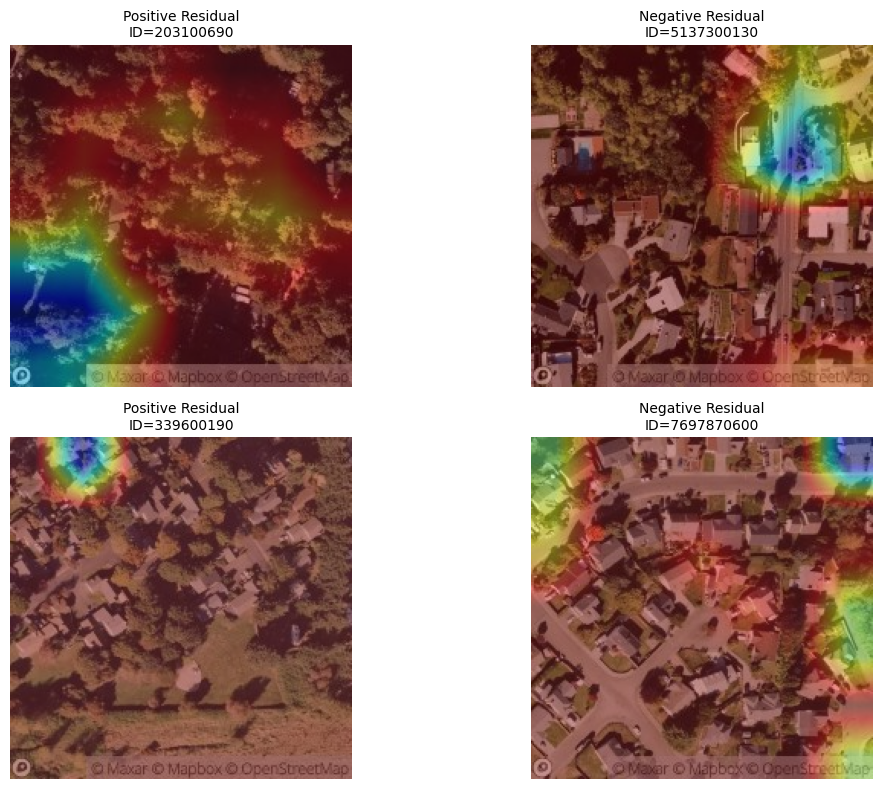

In [16]:
plt.figure(figsize=(12, 8))

num_rows = min(len(pos_indices), len(neg_indices))

for i in range(num_rows):
    for j, (idx, label) in enumerate([
        (pos_indices[i], "Positive Residual"),
        (neg_indices[i], "Negative Residual")
    ]):
        img_tensor, _ = val_ds[idx]
        img_tensor = img_tensor.unsqueeze(0).to(DEVICE)

        pid = int(val_df.iloc[idx]["id"])
        img_path = IMAGES_DIR / "zoom16" / "train" / f"{pid}.png"

        orig_img = cv2.cvtColor(
            cv2.imread(str(img_path)),
            cv2.COLOR_BGR2RGB
        )

        cam = grad_cam.generate(img_tensor)
        cam = cam.squeeze().detach().cpu().numpy()
        cam = cv2.resize(cam, (orig_img.shape[1], orig_img.shape[0]))

        heatmap = cv2.applyColorMap(
            (255 * cam).astype("uint8"),
            cv2.COLORMAP_JET
        )
        overlay = cv2.addWeighted(orig_img, 0.6, heatmap, 0.4, 0)

        plt.subplot(num_rows, 2, 2 * i + j + 1)
        plt.imshow(overlay)

        # Smaller font for ID
        plt.title(
            f"{label}\nID={pid}",
            fontsize=10
        )

        plt.axis("off")

plt.tight_layout()
plt.show()


**Observation:**  
For positive residuals, the CNN focuses on dense urban infrastructure and connectivity,
leading to upward price corrections.  
For negative residuals, attention shifts toward sparse or underdeveloped regions,
resulting in downward adjustments.

This behavior aligns with domain intuition and confirms that the CNN learns
meaningful corrective signals.


In [34]:
idx = np.argmax(np.abs(residuals))
pid = int(val_df.iloc[idx]["id"])

true_val = y_true[idx]
xgb_val = xgb_pred[idx]


In [35]:
img_tensor, _ = val_ds[idx]
img_tensor = img_tensor.unsqueeze(0).to(DEVICE)

cam = grad_cam.generate(img_tensor)
cam = cam.squeeze().detach().cpu().numpy()

img_path = IMAGES_DIR / "zoom16" / "train" / f"{pid}.png"
orig_img = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)

cam = cv2.resize(cam, (orig_img.shape[1], orig_img.shape[0]))
heatmap = cv2.applyColorMap((255 * cam).astype("uint8"), cv2.COLORMAP_JET)
overlay = cv2.addWeighted(orig_img, 0.6, heatmap, 0.4, 0)


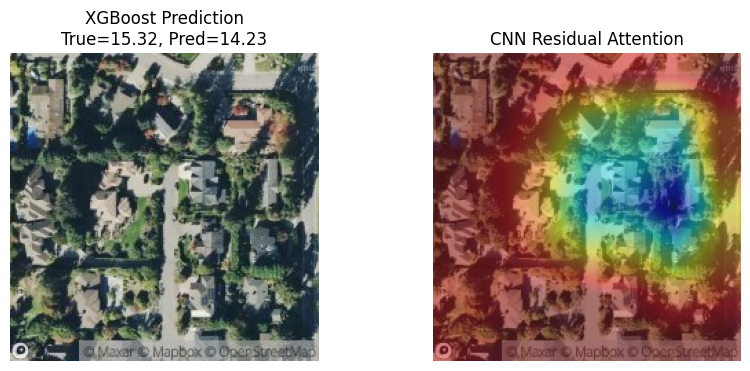

In [36]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(orig_img)
plt.title(
    f"XGBoost Prediction\nTrue={true_val:.2f}, Pred={xgb_val:.2f}"
)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(overlay)
plt.title("CNN Residual Attention")
plt.axis("off")

plt.show()


**Observation:**  
The tabular model underestimates the property value.
The CNN attends to surrounding infrastructure and neighborhood context,
explaining the corrective residual added in the final prediction.


In [37]:
cams = []

for idx in range(50):
    img_tensor, _ = val_ds[idx]
    img_tensor = img_tensor.unsqueeze(0).to(DEVICE)

    cam = grad_cam.generate(img_tensor)
    cam = cam.squeeze().detach().cpu().numpy()
    cams.append(cam)

mean_cam = np.mean(cams, axis=0)
mean_cam /= mean_cam.max()


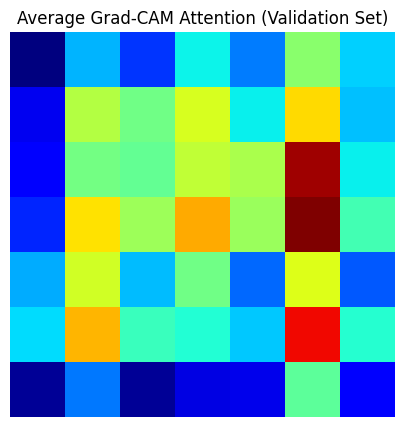

In [38]:
plt.figure(figsize=(5, 5))
plt.imshow(mean_cam, cmap="jet")
plt.title("Average Grad-CAM Attention (Validation Set)")
plt.axis("off")
plt.show()


**Observation:**  
The averaged Grad-CAM highlights consistent attention toward built-up areas
and transportation structures, indicating stable and meaningful spatial learning
across the validation set.


## Grad-CAM Summary

- Grad-CAM reveals that the residual CNN attends to meaningful spatial structures.
- Highlighted regions correspond to neighborhood-level features such as roads and density.
- This confirms that satellite imagery contributes interpretable and complementary
  information beyond tabular predictors.

The Grad-CAM analysis strengthens the credibility and interpretability of the
proposed multimodal residual fusion approach.
